# **Importing and Installing dependencies**

In [1]:
import pandas as pd
import re
import spacy
import pickle
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Text Mining Project/'
with open(path+'anime_summarized.pkl', 'rb') as f:
    anime_df = pickle.load(f)

In [4]:
anime_df

,Name,Genres,Synopsis,Producers,Studios,summarized_synopsis,Image URL
0,Cowboy Bebop,"Fantasy and Supernatural, Action and Adventure","Crime is timeless. By the year 2071, humanity ...",Bandai Visual,Sunrise,"These new societies are plagued by murder, dru...",https://cdn.myanimelist.net/images/anime/4/196...
1,Cowboy Bebop: Tengoku no Tobira,"Fantasy and Supernatural, Action and Adventure","Another day, another bounty—such is the life o...","Sunrise, Bandai Visual",Bones,"Through their individual investigations, they ...",https://cdn.myanimelist.net/images/anime/1439/...
2,Trigun,"Fantasy and Supernatural, Action and Adventure","Vash the Stampede is the man with a $$60,000,0...",Victor Entertainment,Madhouse,With his crazy doughnut obsession and buffooni...,https://cdn.myanimelist.net/images/anime/7/203...
3,Witch Hunter Robin,"Drama and Mistery, Action and Adventure, Fanta...",Robin Sena is a powerful craft user drafted in...,"Bandai Visual, Dentsu, Victor Entertainment, T...",Sunrise,Robin Sena is a powerful craft user drafted in...,https://cdn.myanimelist.net/images/anime/10/19...
4,Bouken Ou Beet,"Fantasy and Supernatural, Action and Adventure",It is the dark century and the people are suff...,"TV Tokyo, Dentsu",Toei Animation,It is the dark century and the people are suff...,https://cdn.myanimelist.net/images/anime/7/215...
...,...,...,...,...,...,...,...
9605,Overtake!,Sport and Slice of Life,Freelance photographer Kouya Madoka is in the ...,"Lantis, F.M.F, Kadokawa",TROYCA,While working on a story at the Fuji Internati...,https://cdn.myanimelist.net/images/anime/1916/...
9606,Jianzhen da Heshang,"Action and Adventure, Sport and Slice of Life","In 742 A.D., the first year of Xuantianbao in ...",NaN,NaN,"In terms of cultural influence, the architectu...",https://cdn.myanimelist.net/images/anime/1391/...
9607,Chang An San Wan Li,Action and Adventure,"A few years after the Anshi Rebellion, the Tib...",NaN,Light Chaser Animation Studios,"A few years after the Anshi Rebellion, the Tib...",https://cdn.myanimelist.net/images/anime/1580/...
9608,Pon no Michi,"Action and Adventure, Comedy and Romance, Spor...","Nashiko Jippensha, a high school girl living i...","Bit grooove promotion, SUPA LOVE",OLM,When Naoko learned that the parlor that her fa...,https://cdn.myanimelist.net/images/anime/1796/...


## **Text Preprocessing**

We preprocess the synopsis for the subsequent analysis.

In [5]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [6]:
stop_words = set(nlp.Defaults.stop_words)
stop_words.add('new')
stop_words.add('world')
stop_words.add('find')
stop_words.add('year')
stop_words.add('life')

In [7]:
def clean_text(text):
  text = text.replace('\n',' ') #remove newlines
  text = text.lower() #lowercase
  text = re.sub(r"\([Ss]ource: [A-Za-z0-9]*\)", "", text) #remove the source of the synopsis
  text = re.sub(r"[^a-z\s]+"," ",text) #remove puntuaction and symbols
  text = " ".join(re.split("\s+", text, flags=re.UNICODE)) #remove multiple whitespaces
  return text

def preprocess_text(text):
  #lemmatize
  doc = nlp(text)
  text = " ".join([token.lemma_ for token in doc])
  text = text.split(' ')
  #remove stopwords
  lst=[]
  for token in text:
    if token not in stop_words:
        lst.append(token)
  text = [word for word in lst]
  return ' '.join(text)

In [8]:
anime_df['preprocessed_synopsis'] = anime_df['Synopsis'].apply(lambda x: preprocess_text(clean_text(x)))

In [9]:
anime_df['preprocessed_synopsis'] = anime_df['preprocessed_synopsis'].apply(lambda x: clean_text(x))

In [10]:
anime_df.head()

,Name,Genres,Synopsis,Producers,Studios,summarized_synopsis,Image URL,preprocessed_synopsis
0,Cowboy Bebop,"Fantasy and Supernatural, Action and Adventure","Crime is timeless. By the year 2071, humanity ...",Bandai Visual,Sunrise,"These new societies are plagued by murder, dru...",https://cdn.myanimelist.net/images/anime/4/196...,crime timeless humanity expand galaxy fill sur...
1,Cowboy Bebop: Tengoku no Tobira,"Fantasy and Supernatural, Action and Adventure","Another day, another bounty—such is the life o...","Sunrise, Bandai Visual",Bones,"Through their individual investigations, they ...",https://cdn.myanimelist.net/images/anime/1439/...,day bounty unlucky crew bebop routine interrup...
2,Trigun,"Fantasy and Supernatural, Action and Adventure","Vash the Stampede is the man with a $$60,000,0...",Victor Entertainment,Madhouse,With his crazy doughnut obsession and buffooni...,https://cdn.myanimelist.net/images/anime/7/203...,vash stampede man bounty head reason s mercile...
3,Witch Hunter Robin,"Drama and Mistery, Action and Adventure, Fanta...",Robin Sena is a powerful craft user drafted in...,"Bandai Visual, Dentsu, Victor Entertainment, T...",Sunrise,Robin Sena is a powerful craft user drafted in...,https://cdn.myanimelist.net/images/anime/10/19...,robin sena powerful craft user draft stnj grou...
4,Bouken Ou Beet,"Fantasy and Supernatural, Action and Adventure",It is the dark century and the people are suff...,"TV Tokyo, Dentsu",Toei Animation,It is the dark century and the people are suff...,https://cdn.myanimelist.net/images/anime/7/215...,dark century people suffer rule devil vandel a...


We tag the data before moving over to the training part.

In [11]:
corpus = anime_df['preprocessed_synopsis'].to_list()

In [12]:
def tag_documents(corpus):
  tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(corpus)]
  return tagged_data

In [13]:
tagged_corpus = tag_documents(corpus)

We make the embeddings for the documents using **Doc2Vec** from *Gensim*.

In [14]:
doc_model = Doc2Vec(tagged_corpus, vector_size=50, min_count=2, epochs=100)
doc_model.build_vocab(tagged_corpus)
doc_model.train(tagged_corpus, total_examples=doc_model.corpus_count, epochs=100)

## **Document Visualization**

In [114]:
doc_tags = list(doc_model.dv.key_to_index)#[0:1000]

In [115]:
doc_tags = list(map(int, doc_tags))

In [116]:
X = doc_model[doc_tags]

In [117]:
pca = PCA(n_components=3)
result = pca.fit_transform(X)

In [118]:
docs = anime_df['Name'][doc_tags].tolist()

In [59]:
anime_df['first_genre'] = anime_df['Genres'].apply(lambda x: x.split(',')[0])

In [119]:
unique_labels = np.unique(anime_df['first_genre'][doc_tags])
colors = pyplot.cm.get_cmap('tab10', len(unique_labels))

label_to_color = {label: colors(i) for i, label in enumerate(unique_labels)}

<ipython-input-119-e2d870191a53>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = pyplot.cm.get_cmap('tab10', len(unique_labels))


In [120]:
len(unique_labels)

9

In [121]:
point_colors = [label_to_color[label] for label in anime_df['first_genre'][doc_tags]]

In [122]:
handles = [pyplot.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors(i), markersize=8) for i in range(len(unique_labels))]

<ipython-input-177-b332829eeb3c>:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, c=point_colors[i])


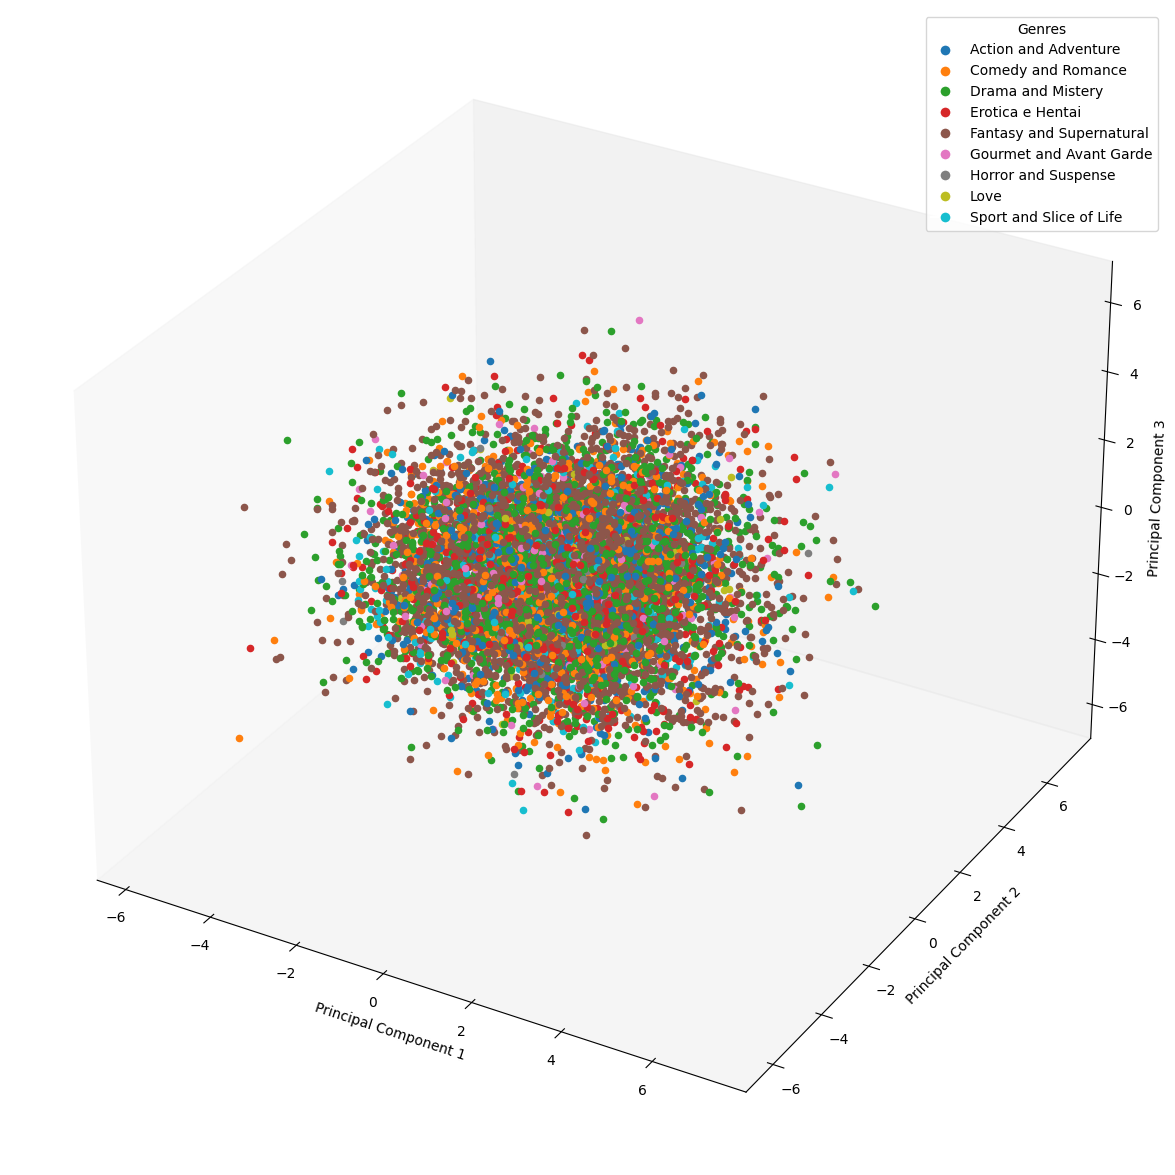

In [177]:
ax = pyplot.figure(figsize=(20,15)).add_subplot(projection='3d')
for i in range(len(docs)):
    x, y, z = result[i][0], result[i][1], result[i][2]
    ax.scatter(x, y, z, c=point_colors[i])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.grid(False)
pyplot.legend(handles, unique_labels, title="Genres")
pyplot.show()





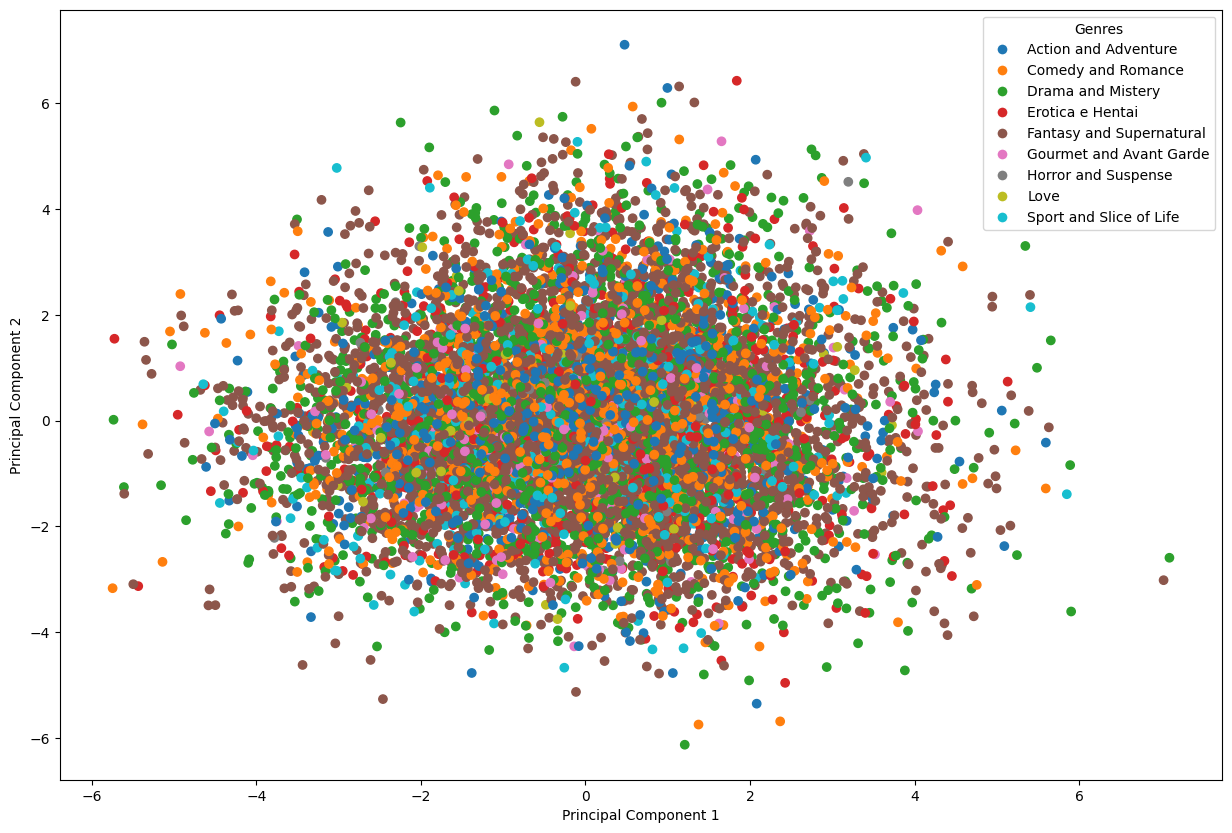

In [124]:
ax = pyplot.figure(figsize=(15,10)).add_subplot()
pyplot.scatter(result[:, 0],
               result[:, 1],
               c=point_colors)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
pyplot.legend(handles, unique_labels, title="Genres")
pyplot.show()

## **Document Embeddings**

We build the embeddings.

In [128]:
d2v_embeddings = np.array([doc_model.infer_vector(anime_df['preprocessed_synopsis'][i].split()) for i in range(anime_df.shape[0])])

We compute the similarity matrix between all the documents using the *cosine similarity*.

In [129]:
similarity_matrix = cosine_similarity(d2v_embeddings, d2v_embeddings)

We define a function to extract the most similar animes from the corpus.

In [130]:
def get_similar_anime(anime_name, sim_matrix=similarity_matrix, top_n=10):
    print(f'The anime most similar to {anime_name} are:')
    anime_id = anime_df[anime_df['Name'] == anime_name].first_valid_index()
    arr = sim_matrix[anime_id]
    return anime_df[['Name', 'Genres', 'Synopsis']].loc[(-arr).argsort()[1:(top_n+1)]]

In [131]:
similar_animes = get_similar_anime('Shingeki no Kyojin')

The anime most similar to Shingeki no Kyojin are:


In [132]:
similar_animes

,Name,Genres,Synopsis
3293,Shin Reyon Densetsu: Mou Hitori no Flair,Erotica e Hentai,An evil entity named Ternel has returned after...
6811,Shingeki no Kyojin Season 3,"Drama and Mistery, Action and Adventure","Still threatened by the ""Titans"" that rob them..."
8862,Shingeki no Kyojin: The Final Season - Kankets...,"Drama and Mistery, Action and Adventure, Horro...",In the wake of Eren Yeager's cataclysmic actio...
6833,Darling in the FranXX,"Drama and Mistery, Action and Adventure, Comed...","In the distant future, humanity has been drive..."
6496,Cocolors,Fantasy and Supernatural,There is a world in which an endless rain of d...
2170,Evangelion: 1.0 You Are (Not) Alone,"Drama and Mistery, Action and Adventure, Fanta...","In a post-apocalyptic world, the last remainin..."
5539,Shingeki no Kyojin Season 2,"Drama and Mistery, Action and Adventure, Horro...","For centuries, humanity has been hunted by gia..."
5123,Gaist Crusher,"Fantasy and Supernatural, Action and Adventure","In the year 2047, mankind discovered a rare me..."
2398,Geisters: Fractions of the Earth,"Fantasy and Supernatural, Action and Adventure","At the end of the 21st century, a meteorite co..."
8467,Shingeki no Kyojin: The Final Season Part 2,"Drama and Mistery, Action and Adventure",Turning against his former allies and enemies ...


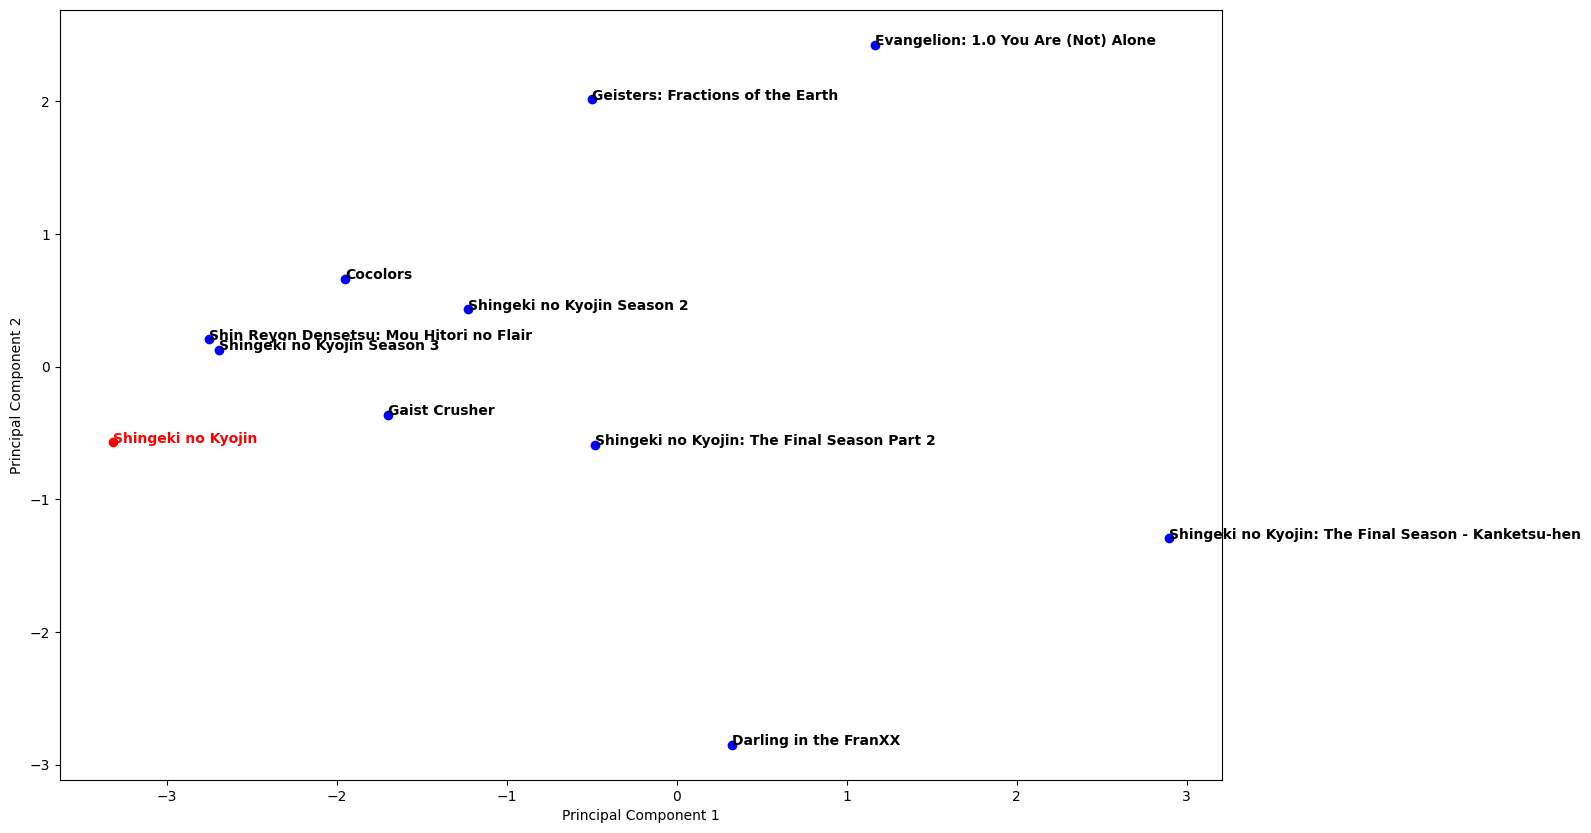

In [174]:
ax = pyplot.figure(figsize=(15,10)).add_subplot()
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')



for i in range(len(similar_animes)):
  id = int(similar_animes.index[i])
  ax.annotate(similar_animes.loc[id]['Name'], xy=(result[id,0], result[id,1]), fontweight = 'bold', size=10)
  pyplot.scatter(result[id, 0], result[id, 1], color = 'blue')

aot_id = anime_df[anime_df['Name']=='Shingeki no Kyojin'].index[0]
ax.annotate(anime_df.loc[aot_id]['Name'], xy=(result[aot_id,0], result[aot_id,1]), fontweight = 'bold', color = 'red', size=10)
pyplot.scatter(result[aot_id, 0], result[aot_id, 1], color = 'red')
pyplot.show()

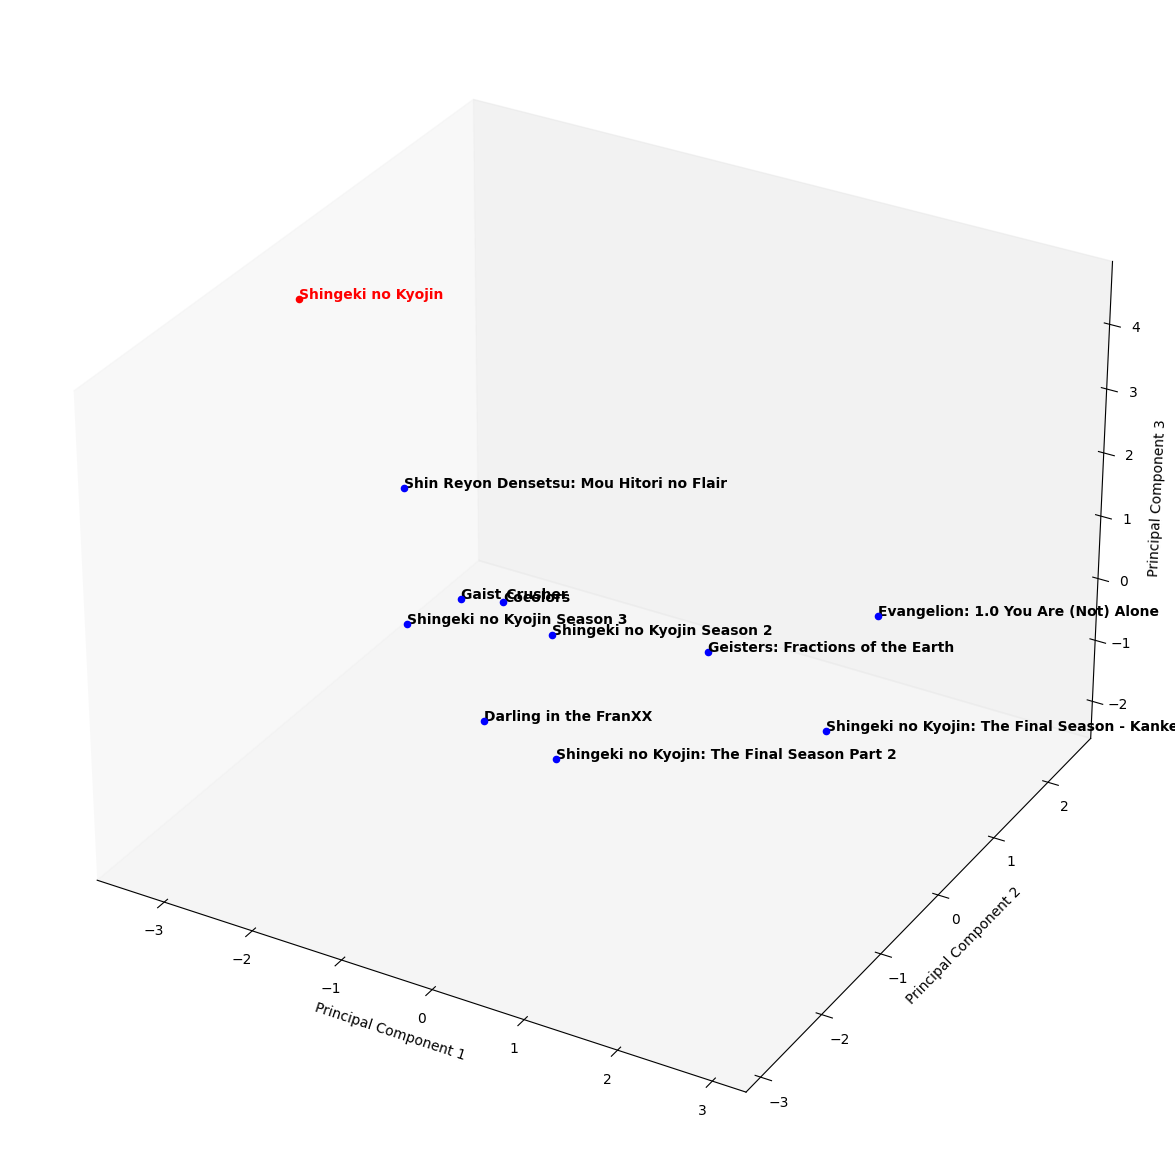

In [176]:
ax = pyplot.figure(figsize=(20,15)).add_subplot(projection='3d')

for i in range(len(similar_animes)):
  id = int(similar_animes.index[i])
  ax.text(result[id,0],result[id,1],result[id,2],similar_animes.loc[id]['Name'], fontweight = 'bold', size=10)
  x, y, z = result[id][0], result[id][1], result[id][2]
  ax.scatter(x, y, z, color = 'blue')

x, y, z = result[aot_id][0], result[aot_id][1], result[aot_id][2]
ax.scatter(x, y, z, color = 'red')
ax.text(result[aot_id,0], result[aot_id,1], result[aot_id,2], anime_df.loc[aot_id]['Name'], fontweight = 'bold', color = 'red', size=10)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.grid(False)



pyplot.show()

# **Saving Embeddings**

In [163]:
similarity_matrix = np.array(similarity_matrix)

In [164]:
np.save(path + 'similarity_matrix.npy', similarity_matrix)